<a href="https://colab.research.google.com/github/lkarjun/fastai-workouts/blob/master/Lesson_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package

In [2]:
!pip install fastai==2.5.3

In [3]:
from fastai.text.all import *

import fastai
fastai.__version__

'2.5.3'

# Loading texts



In [4]:
path = untar_data(URLs.HUMAN_NUMBERS)
path.ls()

(#2) [Path('/root/.fastai/data/human_numbers/valid.txt'),Path('/root/.fastai/data/human_numbers/train.txt')]

In [5]:
lines = L()
with open(path/'train.txt') as f: 
  lines+=L(*f.readlines())
with open(path/'valid.txt') as f: 
  lines+=L(*f.readlines())

lines[:50]

(#50) ['one \n','two \n','three \n','four \n','five \n','six \n','seven \n','eight \n','nine \n','ten \n'...]

In [6]:
text = ' . '.join([l.strip() for l in lines])
text[:100]

'one . two . three . four . five . six . seven . eight . nine . ten . eleven . twelve . thirteen . fo'

In [7]:
tokens = text.split(' ')
tokens[:10]

['one', '.', 'two', '.', 'three', '.', 'four', '.', 'five', '.']

In [8]:
vocab = L(*tokens).unique()
vocab

(#30) ['one','.','two','three','four','five','six','seven','eight','nine'...]

In [9]:
word2idx = {w:i for i, w in enumerate(vocab)}
nums = L(word2idx[i] for i in tokens)
nums

(#63095) [0,1,2,1,3,1,4,1,5,1...]

# Our First Language Model from Scratch

In [10]:
L((tokens[i:i+3], tokens[i+3]) for i in range(0,len(tokens)-4,3))

(#21031) [(['one', '.', 'two'], '.'),(['.', 'three', '.'], 'four'),(['four', '.', 'five'], '.'),(['.', 'six', '.'], 'seven'),(['seven', '.', 'eight'], '.'),(['.', 'nine', '.'], 'ten'),(['ten', '.', 'eleven'], '.'),(['.', 'twelve', '.'], 'thirteen'),(['thirteen', '.', 'fourteen'], '.'),(['.', 'fifteen', '.'], 'sixteen')...]

In [11]:
seqs = L((tensor(nums[i:i+3]), nums[i+3]) for i in range(0,len(nums)-4,3))
seqs

(#21031) [(tensor([0, 1, 2]), 1),(tensor([1, 3, 1]), 4),(tensor([4, 1, 5]), 1),(tensor([1, 6, 1]), 7),(tensor([7, 1, 8]), 1),(tensor([1, 9, 1]), 10),(tensor([10,  1, 11]), 1),(tensor([ 1, 12,  1]), 13),(tensor([13,  1, 14]), 1),(tensor([ 1, 15,  1]), 16)...]

In [12]:
bs = 64
cut = int(len(seqs) * .8)
dls = DataLoaders.from_dsets(seqs[:cut], seqs[cut:], bs = 64, shuffle=False)

# Our Language Model in PyTorch

In [13]:
class LMModel1(Module):

  def __init__(self, vocab_sz, n_hidden):
  
    self.i_h = nn.Embedding(vocab_sz, n_hidden)
    self.h_h = nn.Linear(n_hidden, n_hidden)
    self.h_o = nn.Linear(n_hidden, vocab_sz)

  def forward(self, x):
    
        h = self.i_h(x[:, 0])
        h = self.h_h(h)
        h = F.relu(h)

        h = h + self.i_h(x[:, 1])
        h = self.h_h(h)
        h = F.relu(h)
        
        h = h + self.i_h(x[:, 2])
        h = self.h_h(h)
        h = F.relu(h)

        return self.h_o(h)

In [14]:
learn = Learner(dls, LMModel1(len(vocab), 64), loss_func=F.cross_entropy,
                metrics = [accuracy, perplexity])

In [15]:
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.716415,1.946653,0.463751,7.005205,00:01
1,1.378367,1.787469,0.466841,5.974314,00:01
2,1.399801,1.650023,0.488472,5.207101,00:01
3,1.372525,1.659578,0.477537,5.257091,00:01


In [16]:
c = Counter(tokens[cut: ])

mc = c.most_common(5)
mc

[('thousand', 7104),
 ('.', 7103),
 ('hundred', 6405),
 ('nine', 2440),
 ('eight', 2344)]

**The most common token has the token thousand. Always predicting this token would give us an accuracy of roughly 15\%, so we are faring way better!**

In [17]:
mc[0][1]/len(tokens[cut:])


0.15353028894988222

# First RNN

In [18]:
class LMModel2(Module):
  def __init__(self, vocab_sz, n_hidden):
    self.i_h = nn.Embedding(vocab_sz, n_hidden)
    self.h_h = nn.Linear(n_hidden, n_hidden)
    self.h_o = nn.Linear(n_hidden, vocab_sz)

  def forward(self, x):
    h = 0
    for i in range(3):
      h = h + self.i_h(x[:, i])
      h = self.h_h(h)
      h = F.relu(h)
    return self.h_o(h)

In [19]:
learn = Learner(dls, LMModel2(len(vocab), 64), loss_func=F.cross_entropy, 
                metrics=accuracy)
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.794524,1.937679,0.472783,00:02
1,1.398654,1.794277,0.474210,00:03
2,1.400354,1.728825,0.492750,00:02
3,1.374792,1.721887,0.488947,00:01


**A neural network that is defined using a loop like this is called a recurrent neural network (RNN). It is important to realize that an RNN is not a complicated new architecture, but simply a refactoring of a multilayer neural network using a for loop.**

# Improving The RNN

## Maintain State

In [20]:
class LMModel3(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)  
        self.h_h = nn.Linear(n_hidden, n_hidden)     
        self.h_o = nn.Linear(n_hidden,vocab_sz)
        self.h = 0
        
    def forward(self, x):
        for i in range(3):
            self.h = self.h + self.i_h(x[:,i])
            self.h = F.relu(self.h_h(self.h))
        out = self.h_o(self.h)
        self.h = self.h.detach()
        return out
    
    def reset(self): self.h = 0

In [21]:
a = torch.rand(4, requires_grad=True)
print(a.requires_grad)
b = a.detach()
b.requires_grad

# Detach throw away the gradient.

True


False

In [22]:
m = len(seqs)//bs
m, bs, len(seqs)

(328, 64, 21031)

In [23]:
def group_chunks(ds, bs):
  m = len(ds) // bs
  new_ds = L()
  for i in range(m): new_ds += L(ds[i + m * j] for j in range(bs))
  return new_ds

In [24]:
cut = int(len(seqs) * .8)
dls = DataLoaders.from_dsets(
    group_chunks(seqs[:cut], bs),
    group_chunks(seqs[cut:], bs),
    bs = bs, drop_last = True, shuffle = False
)

In [25]:
ModelResetter??

In [26]:
learn = Learner(dls, LMModel3(len(vocab), 64), loss_func = F.cross_entropy,
                 metrics = accuracy, cbs = ModelResetter)
learn.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.695050,1.846175,0.472837,00:01
1,1.284054,1.817605,0.412981,00:01
2,1.101135,1.596102,0.492308,00:01
3,0.976041,1.656006,0.576202,00:01
4,0.926090,1.534155,0.577404,00:01
5,0.881310,1.451152,0.595913,00:01
6,0.841634,1.587065,0.584375,00:01
7,0.791875,1.540970,0.625721,00:01
8,0.753398,1.573835,0.626923,00:01
9,0.733518,1.565479,0.623317,00:01


## Creating More Signal

In [27]:
sl = 16
seqs = L((tensor(nums[i:i+sl]), tensor(nums[i+1:i+sl+1]))
         for i in range(0,len(nums)-sl-1,sl))
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(group_chunks(seqs[:cut], bs),
                             group_chunks(seqs[cut:], bs),
                             bs=bs, drop_last=True, shuffle=False)

In [28]:
[L(vocab[o] for o in s) for s in seqs[2]]

[(#16) ['seventeen','.','eighteen','.','nineteen','.','twenty','.','twenty','one'...],
 (#16) ['.','eighteen','.','nineteen','.','twenty','.','twenty','one','.'...]]

In [29]:
class LMModel4(Module):
  def __init__(self, vocab_sz, n_hidden):
    self.i_h = nn.Embedding(vocab_sz, n_hidden)
    self.h_h = nn.Linear(n_hidden, n_hidden)
    self.h_o = nn.Linear(n_hidden, vocab_sz)
    self.h = 0

  def forward(self, x):
    outs = []
    for i in range(sl):
      self.h = self.h + self.i_h(x[:, i])
      self.h = F.relu(self.h_h(self.h))
      outs.append(self.h_o(self.h))
    self.h = self.h.detach()
    return torch.stack(outs, dim=1)
  
  def reset(self): self.h = 0


In [30]:
def loss_func(inp, targ):
  return F.cross_entropy(inp.view(-1, len(vocab)), targ.view(-1))

In [31]:
learn = Learner(dls, LMModel4(len(vocab), 64), loss_func = loss_func,
                  metrics = accuracy, cbs = ModelResetter)
learn.fit_one_cycle(1, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.997565,1.906078,0.468913,00:00


## Multilayer RNN

In [32]:
class LMModel5(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        super(LMModel5, self).__init__()
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.RNN(n_hidden, n_hidden, n_layers, batch_first=True)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = torch.zeros(n_layers, bs, n_hidden)
        print(self.h.shape)
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(res)
    
    def reset(self): self.h.zero_()

In [42]:
learn = Learner(dls, LMModel5(len(vocab), 64, 2), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelResetter)
# learn.fit_one_cycle(15, 3e-3)

torch.Size([2, 64, 64])


## Multilayer RNN Implementation

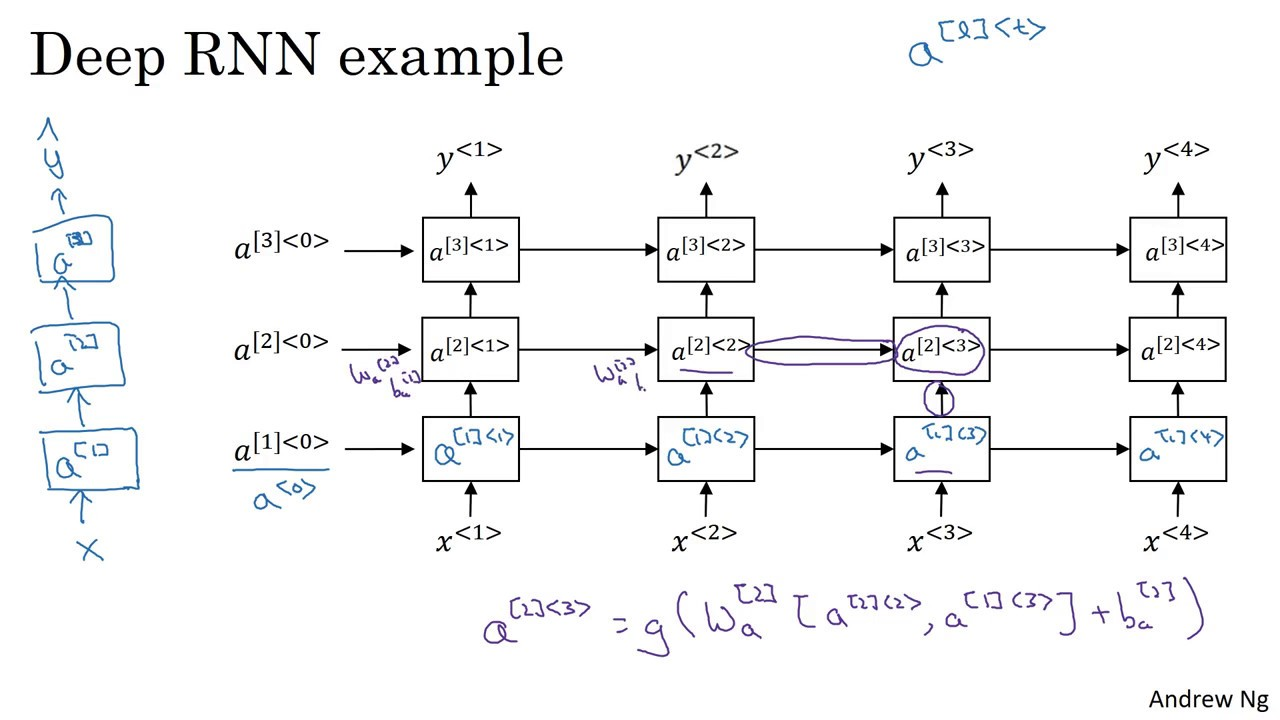

In [34]:
print([L(vocab[o] for o in s) for s in seqs[0]])

print(dls.train_ds[0])

[['one', '.', 'two', '.', 'three', '.', 'four', '.', 'five', '.', 'six', '.', 'seven', '.', 'eight', '.'], ['.', 'two', '.', 'three', '.', 'four', '.', 'five', '.', 'six', '.', 'seven', '.', 'eight', '.', 'nine']]
(tensor([0, 1, 2, 1, 3, 1, 4, 1, 5, 1, 6, 1, 7, 1, 8, 1]), tensor([1, 2, 1, 3, 1, 4, 1, 5, 1, 6, 1, 7, 1, 8, 1, 9]))


In [35]:
print(dls.bs)

64


In [36]:
sample = [torch.rand(64, 30, 3) for _ in range(4)]
print(sample[0].shape)

stack = torch.stack(sample, dim = 1)
print(stack.shape)

torch.Size([64, 30, 3])
torch.Size([64, 4, 30, 3])


In [37]:
a = tensor([1,2,3])
b = tensor([4,4,4])
print(a.shape)
s = torch.stack([a, b], dim=1)
print()
print(s.shape)
print(s)

torch.Size([3])

torch.Size([3, 2])
tensor([[1, 4],
        [2, 4],
        [3, 4]])


In [40]:
class RNN(Module):

  def __init__(self, vocab_sz, sl):
    # length vocab 30
    self.input_hidden = nn.Embedding(vocab_sz, 500)
    self.rnn_1 = nn.Linear(500, 500)
    self.rnn_2 = nn.Linear(500, 500)
    self.hidden_out = nn.Linear(500, vocab_sz)
    self.activation = 0.
    self.sl = sl # length 16

  
  def forward(self, x):
    outs = [] # final outs[0] shape (64, 30), length = 16
    
    for i in range(sl):
      self.activation = self.activation + self.input_hidden(x[:, i])
      self.activation = self.rnn_1(self.activation)
      self.activation = F.relu(self.activation)
      outs.append(self.hidden_out(self.activation))

    self.activation = self.activation.detach()

    return torch.stack(outs, dim=1) # shape (64, 16, 30)
    
  def reset(self):
    self.activation = 0

In [41]:
learn = Learner(dls, RNN(len(vocab), 16), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelResetter)

learn.fit_one_cycle(1, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.609066,2.160034,0.321859,00:03


In [ ]:
img1 = torch.randn(200, 500, 3)
img2 = torch.randn(200, 500, 3)

torch.cat([img1, img2], dim = 1).shape

In [ ]:
import numpy as np


s = [np.random.randn(3, 5) for _ in range(4)]


np.stack(s, axis = 0).shape

In [ ]:
import torch
t1 = torch.tensor([1,1,1])
print(t1.shape)
print(t1.unsqueeze(dim=0).shape)
print(t1.unsqueeze(dim=1).shae)

In [84]:
a  = torch.randn(4,4,4)
a.shape

torch.Size([4, 4, 4])

In [59]:
data = [tensor([1, 11, 22]),
        tensor([2, 12, 23])]

In [61]:
torch.stack(data)

tensor([[ 1, 11, 22],
        [ 2, 12, 23]])

In [65]:
torch.stack(data, dim = 0)

tensor([[ 1, 11, 22],
        [ 2, 12, 23]])

In [64]:
torch.stack(data, dim=1)

tensor([[ 1,  2],
        [11, 12],
        [22, 23]])

In [66]:
torch.stack(data, dim = 2)

IndexError: ignored